# Basic formatting and homogenization of a corpus of annotated parameters 

This notebook demonstrates, using annotations about stereology in thalamus, how to:
1. Get a dataframe from a search performed on a given corpus 
2. Format the data to homogenize them for further analyses:
  1. Rescale the units
  2. Filter out values that cannot be transformed into appropriate units
  3. Interpolate at P14 for data that are age-dependant
  4. Keep only the average values for compound data
3. Save the result as a CSV file

### Update literature annotation corpus

In [1]:
from git import Repo
import os

git_url = "https://github.com/christian-oreilly/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Import required libraries and packages

In [2]:
import matplotlib.pyplot as plt
import collections
import numpy as np
import quantities as pq
from nat.modelingParameter import getParameterTypeNameFromID
from nat.annotationSearch import ParameterGetter, ParameterSearch, ConditionAtom

### List annotated neuronal densities


In [3]:
searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "neuron_density"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True
resultDF = searcher.search()
resultDF["Species"] = [tag[0].name for tag in resultDF["Species"]]
resultDF["Values"] = [param.valuesText() for param in resultDF["obj_parameter"]]
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
0,Thalamus relay cell,Ventral posterior nucleus,[278146. 170264. 88874.4 51258.8 50132.7 ...,mm^-3,Rat
1,Thalamic reticular nucleus cell - PV+,Thalamic reticular nucleus,[867.59597055 796.77030722 794.83949922 717.05...,1/mm^2,Sprague Dawley
2,Thalamus relay cell,Ventral posterolateral nucleus,150.3 +/- 17.5 (n=5.0),mm^-2,Wistar Rat
3,Thalamic reticular nucleus cell - PV+,Thalamic reticular nucleus,[848.57167169 792.13461896 786.37571072 836.99...,1/mm^2,Sprague Dawley
4,Thalamic reticular nucleus cell,Thalamic reticular nucleus - lateral tier,12300.0 +/- 1430.0 (n=8.0),1/mm^3,Long Evans Rat
5,Neuron,Posterior nucleus of thalamus,41477.0 +/- 3612.0 (n=3.0),1/mm^3,Wistar Rat
6,Neuron,Ventral posteromedial nucleus,52494.0 +/- 5082.0 (n=3.0),1/mm^3,Wistar Rat
7,Neuron,Ventral posterolateral nucleus,[133208. 102294. 56182. 52228. 42390. 3488...,mm^-3,Wistar Rat
8,Thalamus interneuron small,dorsal lateral geniculate nucleus,[0.0004 - 0.0008] (n=3.0),1/um^2,Mouse
9,Thalamus interneuron small,Lateral geniculate body,48.4 +/- 12.1 (n=5.0),mm^-2,Wistar Rat


### Rescale to mm⁻³ unit (applying 2D to 3D transformation with the appropriate slice thickness whenever appropriate)

In [4]:
paramGetter = ParameterGetter(pathDB="neurocuratorDB")

values = []
units  = []

def rescale2DStereo(paramID, thicknessValue=1.0, thicknessUnit="um", desiredUnit="mm^-3"):
    density = paramGetter.getParam(paramID)
    thickness = pq.Quantity(thicknessValue, thicknessUnit)
    return (density/thickness).rescale(desiredUnit)

for param, annot, (index, row) in zip(resultDF["obj_parameter"], 
                                      resultDF["obj_annotation"], 
                                      resultDF.iterrows()):
    try:
        param = param.rescale("mm^-3")
    except ValueError:
        thicknessInstanceId = [param.instanceId for param in annot.experimentProperties 
                                if getParameterTypeNameFromID(param.paramTypeId) == "slice_thickness"]

        if len(thicknessInstanceId) == 1:
            thicknessParameter = paramGetter.getParam(thicknessInstanceId[0])
            if len(thicknessParameter.values) == 1:
                param = rescale2DStereo(param.id, thicknessValue=thicknessParameter.values[0], 
                                        thicknessUnit=thicknessParameter.unit, 
                                        desiredUnit="mm^-3")
    units.append(param.unit)
    values.append(param.valuesText())
    resultDF.loc[index, "obj_parameter"] = param   
    
resultDF["Values"] = values
resultDF["Unit"]   = units
    
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
0,Thalamus relay cell,Ventral posterior nucleus,[278146. 170264. 88874.4 51258.8 50132.7 ...,mm^-3,Rat
1,Thalamic reticular nucleus cell - PV+,Thalamic reticular nucleus,[867.59597055 796.77030722 794.83949922 717.05...,1/mm^2,Sprague Dawley
2,Thalamus relay cell,Ventral posterolateral nucleus,150300.00000000003 +/- 17500.000000000004 (n=...,1/mm**3,Wistar Rat
3,Thalamic reticular nucleus cell - PV+,Thalamic reticular nucleus,[848.57167169 792.13461896 786.37571072 836.99...,1/mm^2,Sprague Dawley
4,Thalamic reticular nucleus cell,Thalamic reticular nucleus - lateral tier,12300.0 +/- 1430.0 (n=8.0),1/mm**3,Long Evans Rat
5,Neuron,Posterior nucleus of thalamus,41477.0 +/- 3612.0 (n=3.0),1/mm**3,Wistar Rat
6,Neuron,Ventral posteromedial nucleus,52494.0 +/- 5082.0 (n=3.0),1/mm**3,Wistar Rat
7,Neuron,Ventral posterolateral nucleus,[133208. 102294. 56182. 52228. 42390. 3488...,mm^-3,Wistar Rat
8,Thalamus interneuron small,dorsal lateral geniculate nucleus,[5714.285714285716 - 11428.571428571431] (n=...,1/mm**3,Mouse
9,Thalamus interneuron small,Lateral geniculate body,48400.00000000001 +/- 12100.000000000002 (n=5.0),1/mm**3,Wistar Rat


### Keep only the annotations that could successfully be rescaled to a common unit (mm⁻³)

In [5]:
resultDF = resultDF[resultDF["Unit"] == "1/mm**3"]
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
2,Thalamus relay cell,Ventral posterolateral nucleus,150300.00000000003 +/- 17500.000000000004 (n=...,1/mm**3,Wistar Rat
4,Thalamic reticular nucleus cell,Thalamic reticular nucleus - lateral tier,12300.0 +/- 1430.0 (n=8.0),1/mm**3,Long Evans Rat
5,Neuron,Posterior nucleus of thalamus,41477.0 +/- 3612.0 (n=3.0),1/mm**3,Wistar Rat
6,Neuron,Ventral posteromedial nucleus,52494.0 +/- 5082.0 (n=3.0),1/mm**3,Wistar Rat
8,Thalamus interneuron small,dorsal lateral geniculate nucleus,[5714.285714285716 - 11428.571428571431] (n=...,1/mm**3,Mouse
9,Thalamus interneuron small,Lateral geniculate body,48400.00000000001 +/- 12100.000000000002 (n=5.0),1/mm**3,Wistar Rat
10,Neuron,Dorsal nucleus of lateral geniculate body,[32034. 22786. 21993. 16666.] +/- [827. 930. 4...,1/mm**3,Wistar Rat
11,Thalamic reticular nucleus cell - non-GABAergic,Thalamic reticular nucleus,[19500. 45300. 44600. 48800.] +/- [11800. 900...,1/mm**3,Wistar Rat
13,Thalamic reticular nucleus cell - GABAergic,Thalamic reticular nucleus,[142900. 178500. 185100. 215800.] +/- [17300. ...,1/mm**3,Wistar Rat
14,Thalamus relay cell,Ventral posteromedial nucleus,304300.00000000006 +/- 16600.000000000004 (n=...,1/mm**3,Wistar Rat


### Some of the annotations are actually "numerical traces" which can be displayed...

In [6]:
resultDF[resultDF["Result type"] == "numericalTrace"]

,AgeCategories,Cell,Context,Parameter instance ID,Parameter name,Parameter type ID,Regional part of brain,Result type,Species,Text,Unit,Values,obj_annotation,obj_parameter
10,[],Neuron,,efe17746-f460-11e7-b8d3-acbc328c3997,neuron_density,BBP-131001,Dorsal nucleus of lateral geniculate body,numericalTrace,Wistar Rat,Table 1,1/mm**3,[32034. 22786. 21993. 16666.] +/- [827. 930. 4...,"""c5b8fb00-f21b-11e7-8ae1-acbc328c3997"";""Values...","{'id': 'efe17746-f460-11e7-b8d3-acbc328c3997',..."
11,[],Thalamic reticular nucleus cell - non-GABAergic,,df6bbbe6-75f5-11e6-8584-64006a4c56ef,neuron_density,BBP-131001,Thalamic reticular nucleus,numericalTrace,Wistar Rat,Table 1,1/mm**3,[19500. 45300. 44600. 48800.] +/- [11800. 900...,"""a65f744c-6f91-11e6-81bd-64006a4c56ef"";""Mean d...","{'id': 'df6bbbe6-75f5-11e6-8584-64006a4c56ef',..."
13,[],Thalamic reticular nucleus cell - GABAergic,,8873cc86-6f95-11e6-81bd-64006a4c56ef,neuron_density,BBP-131001,Thalamic reticular nucleus,numericalTrace,Wistar Rat,Table 1,1/mm**3,[142900. 178500. 185100. 215800.] +/- [17300. ...,"""5873d61a-6f91-11e6-81bd-64006a4c56ef"";""Mean d...","{'id': '8873cc86-6f95-11e6-81bd-64006a4c56ef',..."
18,[],Neuron,,96c4c024-319f-11e8-b594-64006a67e5d0,neuron_density,BBP-131001,Ventral posterolateral nucleus,numericalTrace,C57BL,Figure 4.B,1/mm**3,[587212. 538107. 564706. 529923. 599488. 60358...,"""bfa38df6-319d-11e8-b594-64006a67e5d0"";""How ma...","{'id': '96c4c024-319f-11e8-b594-64006a67e5d0',..."
19,[],Thalamus relay cell,,ddebdeb5-7e95-11e7-8d14-64006a67e5d0,neuron_density,BBP-131001,Ventral posterolateral nucleus,numericalTrace,Long Evans Rat,"Figure 3, right",1/mm**3,[103040.45617248 60975.66987657 53202.586824...,"""ddebdeb4-7e95-11e7-8d14-64006a67e5d0"";""Obtain...","{'id': 'ddebdeb5-7e95-11e7-8d14-64006a67e5d0',..."
26,[],Neuron,,5b114858-31a0-11e8-b594-64006a67e5d0,neuron_density,BBP-131001,Ventral lateral nucleus,numericalTrace,C57BL,Figure 4.D,1/mm**3,[348586. 375321. 384576. 393830. 387661. 37223...,"""f89b07d0-319f-11e8-b594-64006a67e5d0"";""How ma...","{'id': '5b114858-31a0-11e8-b594-64006a67e5d0',..."
28,[],Thalamus relay cell,,a39b208a-7e95-11e7-8d14-64006a67e5d0,neuron_density,BBP-131001,Ventral posteromedial nucleus,numericalTrace,Long Evans Rat,"Figure 3, left",1/mm**3,[99733.98155278 60344.97407882 54166.70486108]...,"""26534131-7e95-11e7-8d14-64006a67e5d0"";""Obtain...","{'id': 'a39b208a-7e95-11e7-8d14-64006a67e5d0',..."
33,[],Thalamus relay cell,,600c5209-7e90-11e7-8d14-64006a67e5d0,neuron_density,BBP-131001,Ventral posterior nucleus,numericalTrace,Long Evans Rat,"Figure 2, middle panel",1/mm**3,[270405. 184424. 103427. 63551.4 53582.6 ...,"""600c5208-7e90-11e7-8d14-64006a67e5d0"";""Labele...","{'id': '600c5209-7e90-11e7-8d14-64006a67e5d0',..."
36,[],Neuron,,f39973ee-319f-11e8-b594-64006a67e5d0,neuron_density,BBP-131001,Ventral posteromedial nucleus,numericalTrace,C57BL,Figure 4.C,1/mm**3,[521600. 555200. 528000. 499200. 507200. 46400...,"""9c830e62-319f-11e8-b594-64006a67e5d0"";""How ma...","{'id': 'f39973ee-319f-11e8-b594-64006a67e5d0',..."


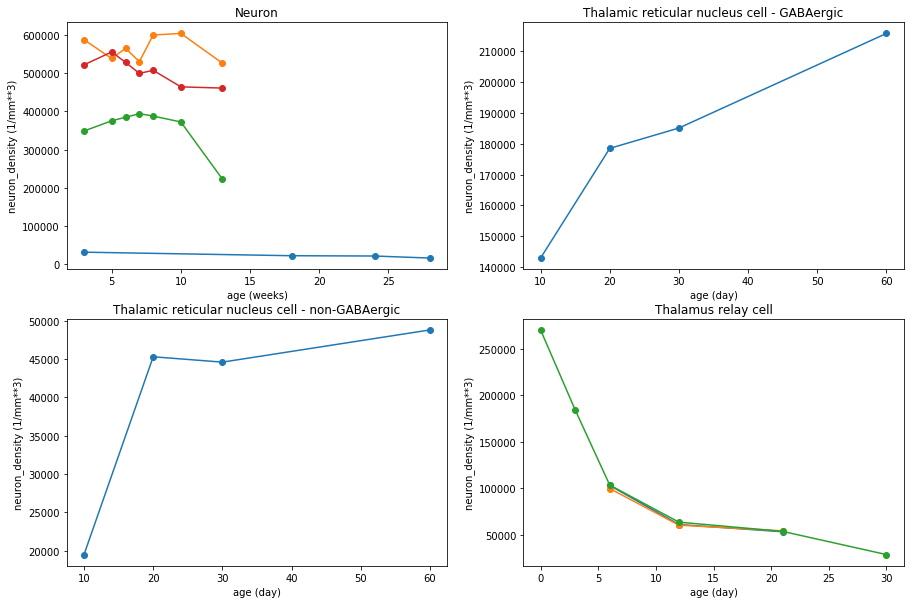

In [7]:
%matplotlib inline

def getFigTrace(param, title="", xlim=None, context=None, index=0):
    if context is None:
        fig, axes = plt.subplots()
    else:
        fig, axarr = context
        if isinstance(axarr, collections.Iterable):
            axes = axarr[index]
        else:
            axes = axarr
        
    axes.plot(param.indepValues[0], param.means, '-o')
    if not xlim is None:
        axes.set_xlim(xlim)
        
    axes.set_ylabel(param.name + " (" + param.unit + ")")
    axes.set_xlabel(param.indepNames[0] + " (" + param.indepUnits[0] + ")")
    axes.set_title(title)
    return fig    

paramTraces = resultDF[resultDF["Result type"] == "numericalTrace"]["obj_parameter"].values
cellTypes   = resultDF[resultDF["Result type"] == "numericalTrace"]["Cell"].values

unique_cell_type = list(np.unique(cellTypes))
context = plt.subplots(2, int(np.ceil(len(unique_cell_type)/2.0)), figsize=(15, 10))
for paramTrace, cellType in zip(paramTraces, cellTypes):
    no = unique_cell_type.index(cellType)
    fig = getFigTrace(paramTrace, title=cellType, context=context, index=(int(no/2), no%2))

### As value, we  want to take the value interpolated at P14. Two of these curves have points specified as mean +/- sem (N=sample_size) from which we only consider the mean values

In [8]:
finalValues = np.zeros((len(resultDF["Result type"])))
for ind, (paramTrace, resType) in enumerate(zip(resultDF["obj_parameter"], resultDF["Result type"])):
    if resType == "numericalTrace":
        val = paramTrace.getInterp1dValues(14, "age", statsToReturn=["mean", "raw"])
        if isinstance(val, list):
            val = val[0]
        finalValues[ind] = float(val)    
        print("Interpolated value:", finalValues[ind])

Interpolated value: 25252.13333333333
Interpolated value: 29820.0
Interpolated value: 157140.00000000003
Interpolated value: 587212.0
Interpolated value: 59248.31808711983
Interpolated value: 348586.0
Interpolated value: 58972.02536376574
Interpolated value: 61336.11111111111
Interpolated value: 521600.0


### The other parameters are also specified as mean +/- std (N=sample_size) from which we only consider the mean value

In [9]:
for ind, (param, resType) in enumerate(zip(resultDF["obj_parameter"], resultDF["Result type"])):
    if resType != "numericalTrace":
        if param.means is None:
            finalValues[ind] = None            
        else:
            finalValues[ind] = np.mean(param.means)

resultDF["Values"] = finalValues            
resultDF = resultDF[np.logical_not(np.isnan(resultDF["Values"]))]            
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
2,Thalamus relay cell,Ventral posterolateral nucleus,150300.000000,1/mm**3,Wistar Rat
4,Thalamic reticular nucleus cell,Thalamic reticular nucleus - lateral tier,12300.000000,1/mm**3,Long Evans Rat
5,Neuron,Posterior nucleus of thalamus,41477.000000,1/mm**3,Wistar Rat
6,Neuron,Ventral posteromedial nucleus,52494.000000,1/mm**3,Wistar Rat
9,Thalamus interneuron small,Lateral geniculate body,48400.000000,1/mm**3,Wistar Rat
10,Neuron,Dorsal nucleus of lateral geniculate body,25252.133333,1/mm**3,Wistar Rat
11,Thalamic reticular nucleus cell - non-GABAergic,Thalamic reticular nucleus,29820.000000,1/mm**3,Wistar Rat
13,Thalamic reticular nucleus cell - GABAergic,Thalamic reticular nucleus,157140.000000,1/mm**3,Wistar Rat
14,Thalamus relay cell,Ventral posteromedial nucleus,304300.000000,1/mm**3,Wistar Rat
15,Thalamic reticular nucleus cell,Thalamic reticular nucleus - medial tier,18120.000000,1/mm**3,Long Evans Rat


### Save resulting dataframe for further analyses

In [10]:
resultDF.to_csv("stereology_param_sample.csv", index=False)